In [1]:
import os
import json
import numpy as np
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import functional as F
from sklearn.metrics import accuracy_score

In [ ]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.entries = data 
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(all_categories))}
        else:
            self.category_map = category_map

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        image_path = os.path.join(self.image_root, entry['image']['pathname'].lstrip('/'))
        image = Image.open(image_path).convert("RGB")

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            x_min = bb['minimum']['c']
            y_min = bb['minimum']['r']
            x_max = bb['maximum']['c']
            y_max = bb['maximum']['r']
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return image, target


train_transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


root_path = 'dataset'
train_json = os.path.join(root_path, 'training.json')
test_json = os.path.join(root_path, 'test.json')
image_root = root_path  

train_ds = MalariaDataset(train_json, image_root, transform=train_transform)
test_ds = MalariaDataset(test_json, image_root, transform=test_transform, category_map=train_ds.category_map)


In [3]:
class ResNetDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()

        self.classifier = nn.Linear(512, num_classes)

        self.bbox_head = nn.Linear(512, 4)

    def forward(self, x):
        features = self.backbone(x)

        class_scores = self.classifier(features)

        bbox_preds = self.bbox_head(features)

        return class_scores, bbox_preds

In [4]:
def margin_loss(class_scores, targets, margin=0.2):
    """ Margin loss for the class scores """
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()

    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)

    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    """
    Smooth L1 loss for bounding box regression with masking.
    Args:
        preds: Predicted bounding boxes [4] or [num_preds, 4].
        targets: Ground truth bounding boxes [num_targets, 4].
    """
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)  

    num_preds = preds.size(0)
    num_targets = targets.size(0)

    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)

    return F.smooth_l1_loss(preds, targets)

def custom_collate_fn(batch):
    """ Custom collate function to handle variable-sized bounding boxes and labels """
    images = []
    targets = {'boxes': [], 'labels': []}
    
    for image, target in batch:
        images.append(image)
        targets['boxes'].append(target['boxes'])
        targets['labels'].append(target['labels'])

    images = torch.stack(images, dim=0)
    
    return images, targets

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


Epoch 1/10


Training Epoch 1: 100%|██████████| 38/38 [02:50<00:00,  4.49s/batch, loss=12.3]


Train Epoch: 1, Loss: 19.0434, Accuracy: 76.74%


Validating: 100%|██████████| 4/4 [00:06<00:00,  1.53s/batch, loss=14.9]


Validation Loss: 18.7537, Accuracy: 79.77%
Epoch 2/10


Training Epoch 2: 100%|██████████| 38/38 [02:26<00:00,  3.85s/batch, loss=13.1]


Train Epoch: 2, Loss: 16.5948, Accuracy: 89.97%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/batch, loss=15]


Validation Loss: 18.7559, Accuracy: 74.03%
Epoch 3/10


Training Epoch 3: 100%|██████████| 38/38 [02:26<00:00,  3.85s/batch, loss=12.3]


Train Epoch: 3, Loss: 16.3800, Accuracy: 90.61%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch, loss=14.4]


Validation Loss: 18.2725, Accuracy: 76.82%
Epoch 4/10


Training Epoch 4: 100%|██████████| 38/38 [02:26<00:00,  3.87s/batch, loss=12.3]


Train Epoch: 4, Loss: 16.1336, Accuracy: 88.89%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.33s/batch, loss=14]


Validation Loss: 17.7821, Accuracy: 80.99%
Epoch 5/10


Training Epoch 5: 100%|██████████| 38/38 [02:25<00:00,  3.84s/batch, loss=11.9]


Train Epoch: 5, Loss: 16.0019, Accuracy: 86.22%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.42s/batch, loss=13.9]


Validation Loss: 17.7305, Accuracy: 60.74%
Epoch 6/10


Training Epoch 6: 100%|██████████| 38/38 [02:26<00:00,  3.85s/batch, loss=11.8]


Train Epoch: 6, Loss: 16.0058, Accuracy: 86.56%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch, loss=13.9]


Validation Loss: 17.6951, Accuracy: 86.15%
Epoch 7/10


Training Epoch 7: 100%|██████████| 38/38 [02:27<00:00,  3.87s/batch, loss=12]


Train Epoch: 7, Loss: 15.9905, Accuracy: 86.64%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.31s/batch, loss=14]


Validation Loss: 17.7588, Accuracy: 86.31%
Epoch 8/10


Training Epoch 8: 100%|██████████| 38/38 [02:27<00:00,  3.87s/batch, loss=12.1]


Train Epoch: 8, Loss: 15.8613, Accuracy: 82.56%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.29s/batch, loss=14]


Validation Loss: 17.7544, Accuracy: 86.81%
Epoch 9/10


Training Epoch 9: 100%|██████████| 38/38 [02:26<00:00,  3.85s/batch, loss=12]


Train Epoch: 9, Loss: 15.8263, Accuracy: 80.20%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.35s/batch, loss=13.9]


Validation Loss: 17.6715, Accuracy: 69.60%
Epoch 10/10


Training Epoch 10: 100%|██████████| 38/38 [02:25<00:00,  3.83s/batch, loss=12]


Train Epoch: 10, Loss: 15.8452, Accuracy: 81.90%


Validating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/batch, loss=14.1]


Validation Loss: 17.8216, Accuracy: 89.14%


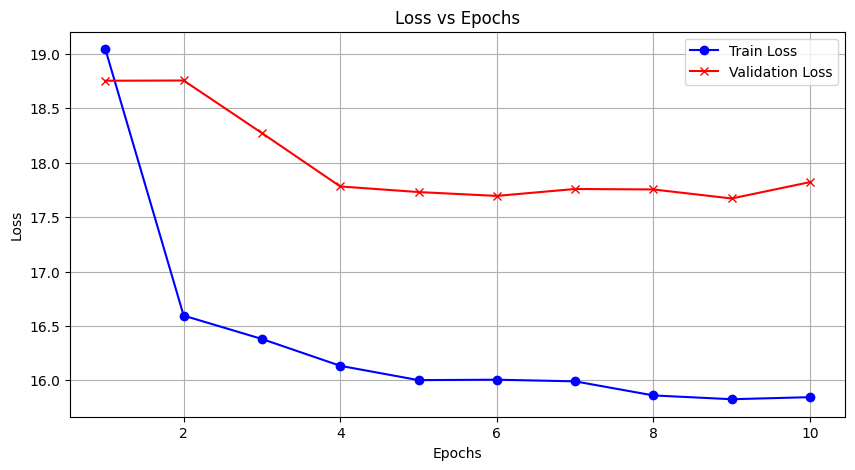

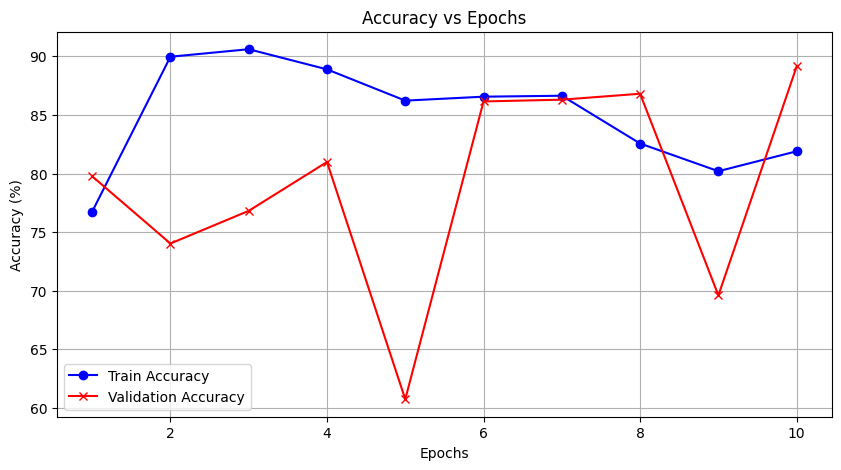

In [5]:
def train_model(model, train_loader, optimizer, epoch, device, metric_history):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    class_weight = 1.0
    bbox_weight = 0.1 

    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", unit="batch")
    for images, targets in pbar:
        images = images.to(device)

        targets['boxes'] = [box.to(device) for box in targets['boxes']]
        targets['labels'] = [label.to(device) for label in targets['labels']]

        optimizer.zero_grad()

        class_scores, bbox_preds = model(images)

        class_loss = 0
        bbox_loss_val = 0
        for i in range(len(targets['boxes'])):
            image_width, image_height = 128, 128
            targets['boxes'][i][:, [0, 2]] /= image_width  # x_min, x_max
            targets['boxes'][i][:, [1, 3]] /= image_height  # y_min, y_max

            class_loss += margin_loss(class_scores[i], targets['labels'][i])
            bbox_loss_val += bbox_loss(bbox_preds[i], targets['boxes'][i])

        loss = class_weight * class_loss + bbox_weight * bbox_loss_val

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted_classes = torch.argmax(class_scores, dim=-1)
        for i in range(len(targets['labels'])):
            correct += (predicted_classes[i] == targets['labels'][i]).sum().item()
            total += targets['labels'][i].size(0)

        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Train Epoch: {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    metric_history['train_loss'].append(epoch_loss)
    metric_history['train_accuracy'].append(accuracy)

    return epoch_loss, accuracy


def validate_model(model, val_loader, device, metric_history):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    class_weight = 1.0
    bbox_weight = 0.1  

    pbar = tqdm(val_loader, desc="Validating", unit="batch")
    with torch.no_grad():
        for images, targets in pbar:
            images = images.to(device)

            # Перенос targets на устройство
            targets['boxes'] = [box.to(device) for box in targets['boxes']]
            targets['labels'] = [label.to(device) for label in targets['labels']]

            class_scores, bbox_preds = model(images)

            class_loss = 0
            bbox_loss_val = 0
            for i in range(len(targets['boxes'])):
                image_width, image_height = 128, 128
                targets['boxes'][i][:, [0, 2]] /= image_width  # x_min, x_max
                targets['boxes'][i][:, [1, 3]] /= image_height  # y_min, y_max

                class_loss += margin_loss(class_scores[i], targets['labels'][i])
                bbox_loss_val += bbox_loss(bbox_preds[i], targets['boxes'][i])

            loss = class_weight * class_loss + bbox_weight * bbox_loss_val

            running_loss += loss.item()

            predicted_classes = torch.argmax(class_scores, dim=-1)
            for i in range(len(targets['labels'])):
                correct += (predicted_classes[i] == targets['labels'][i]).sum().item()
                total += targets['labels'][i].size(0)

            pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(val_loader)
    accuracy = correct / total * 100
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    metric_history['val_loss'].append(epoch_loss)
    metric_history['val_accuracy'].append(accuracy)

    return epoch_loss, accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetDetector(num_classes=len(train_ds.category_map)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

metric_history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, epoch, device, metric_history)
    val_loss, val_accuracy = validate_model(model, val_loader, device, metric_history)

    torch.save(model.state_dict(), f"resnet_model_epoch_{epoch}.pth")

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, metric_history['train_loss'], label='Train Loss', color='blue', marker='o')
plt.plot(epochs, metric_history['val_loss'], label='Validation Loss', color='red', marker='x')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, metric_history['train_accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(epochs, metric_history['val_accuracy'], label='Validation Accuracy', color='red', marker='x')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from torchvision.transforms import ToPILImage

def visualize_prediction(model, dataset, device, category_map, threshold=0.5):
    model.eval()  

    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    image = image.to(device).unsqueeze(0)  

    with torch.no_grad():
        class_scores, bbox_preds = model(image)

    to_pil = ToPILImage()
    image = to_pil(image.squeeze(0).cpu())

    bbox_preds = bbox_preds.squeeze(0).cpu()
    class_scores = class_scores.squeeze(0).cpu()

    if bbox_preds.ndim == 1:
        bbox_preds = bbox_preds.unsqueeze(0)  

    if class_scores.ndim == 1:
        class_scores = class_scores.unsqueeze(0) 

    if bbox_preds.size(0) != class_scores.size(0):
        raise ValueError(f"Mismatch between number of predicted boxes ({bbox_preds.size(0)}) and class scores ({class_scores.size(0)}).")

    selected_boxes = []
    selected_labels = []
    for i, score in enumerate(class_scores):
        if score.max() > threshold: 
            selected_boxes.append(bbox_preds[i].tolist())
            selected_labels.append(score.argmax().item())

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(selected_boxes, selected_labels):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

        if label in category_map:
            label_text = category_map[label]
        else:
            label_text = f"Unknown ({label})"  

        ax.text(x_min, y_min - 5, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.title("Predictions with Bounding Boxes and Labels")
    plt.show()

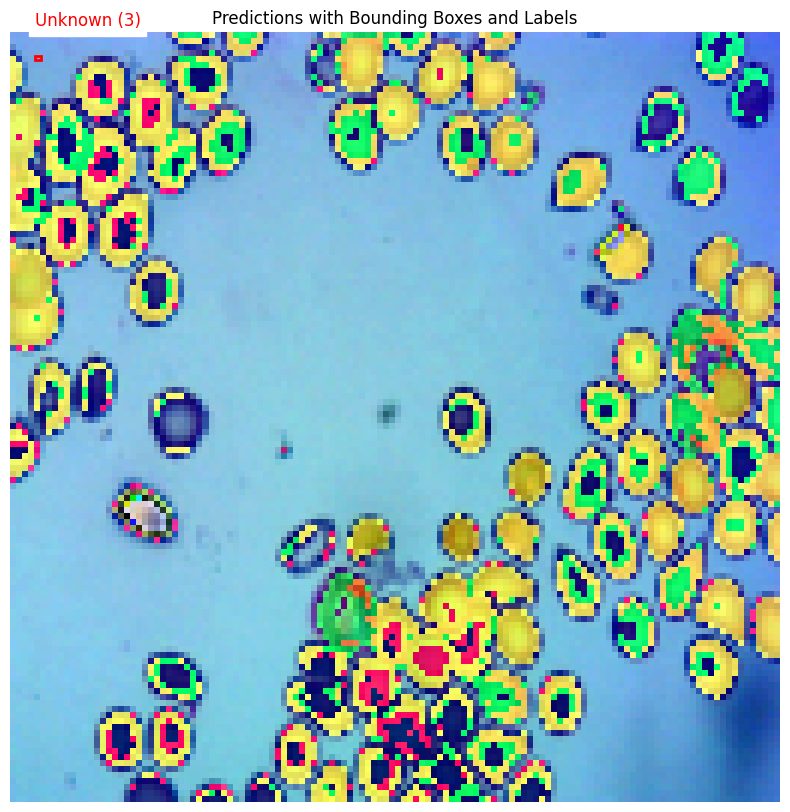

In [7]:
visualize_prediction(model, test_ds, device, train_ds.category_map, threshold=0.5)